In [1]:
is_Ubuntu = True

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn import preprocessing
import tensorflow as tf
import tensorflow
from tensorflow import keras
from functools import reduce

%matplotlib inline

if is_Ubuntu:
    H_Wildfires = pd.read_csv(r'../data/Nov_10/Historical_Wildfires.csv')
    H_Weather = pd.read_csv(r'../data/Nov_10/HistoricalWeather.csv')
    H_Weather_Fc = pd.read_csv(r'../data/Nov_10/HistoricalWeatherForecasts.csv')
    LandClass = pd.read_csv(r'../data/Nov_10/LandClass.csv')
    Vege = pd.read_csv(r'../data/Nov_10/VegetationIndex.csv')
    Sample = pd.read_csv(r'../data/submission-example.csv')

one of two input will be necessary in Std&Var to improve computation
I will keep Var and discard Std

In [2]:
H_Wildfires = H_Wildfires.dropna() 
H_Wildfires=H_Wildfires.drop(columns='Std_confidence')

In [3]:
def reform(df, target_column, common_cols, key_cols, param_cols):
    elements = df[target_column].unique()
    basis = df[common_cols].drop_duplicates()
    for elm in elements:
        new = df[df[target_column] == elm][key_cols + param_cols]
        rename = {}
        for col in param_cols:
            rename[col] = str(elm) + '_' + col
        new = new.rename(columns=rename)
        basis = basis.merge(new, on=key_cols)
    return basis

In [4]:
target_column = 'Parameter'
common_cols = ['Date', 'Region', 'count()[unit: km^2]']
common_cols_fc = ['Date', 'Region', 'Lead time', 'count()[unit: km^2]']
key_cols = ['Date', 'Region']
key_cols_fc = ['Date', 'Region', 'Lead time']
param_cols = ['min()', 'max()', 'mean()', 'variance()']

H_Weather_reform = reform(H_Weather.copy(), target_column, common_cols, key_cols, param_cols)
H_Weather_Fc_reform = reform(H_Weather_Fc.copy(), target_column, common_cols_fc, key_cols_fc, param_cols)

In [5]:
H_Weather_Fc_reform.head(2)

,Date,Region,Lead time,count()[unit: km^2],RelativeHumidity_min(),RelativeHumidity_max(),RelativeHumidity_mean(),RelativeHumidity_variance(),SolarRadiation_min(),SolarRadiation_max(),...,Temperature_mean(),Temperature_variance(),WindSpeed_min(),WindSpeed_max(),WindSpeed_mean(),WindSpeed_variance(),Precipitation_min(),Precipitation_max(),Precipitation_mean(),Precipitation_variance()
0,2015-07-06,NSW,5,8.037682e+05,36.506927,96.380577,62.832873,144.521980,1.310407,14.294098,...,10.280841,5.677777,1.183472,7.471239,3.541415,1.095084,0.0,0.676588,0.015649,0.004120
1,2015-07-06,NT,5,1.349817e+06,22.928360,75.619980,40.378507,144.540934,8.691142,20.307533,...,18.207019,14.549913,1.600128,9.407453,3.861081,1.025623,0.0,1.775728,0.017325,0.012745


In [6]:
target_column2 = 'Lead time'
common_cols_fc2 = ['Date', 'Region', 'count()[unit: km^2]']
key_cols_fc2 = ['Date', 'Region']
param_cols = H_Weather_Fc_reform.columns[4:].tolist()
H_Weather_Fc_reform = reform(H_Weather_Fc_reform.copy(), target_column2, common_cols_fc2, key_cols_fc2, param_cols)
H_Weather_Fc_reform # If you don't want this lead time shape, just deactivate this cell.

,Date,Region,count()[unit: km^2],5_RelativeHumidity_min(),5_RelativeHumidity_max(),5_RelativeHumidity_mean(),5_RelativeHumidity_variance(),5_SolarRadiation_min(),5_SolarRadiation_max(),5_SolarRadiation_mean(),...,15_Temperature_mean(),15_Temperature_variance(),15_WindSpeed_min(),15_WindSpeed_max(),15_WindSpeed_mean(),15_WindSpeed_variance(),15_Precipitation_min(),15_Precipitation_max(),15_Precipitation_mean(),15_Precipitation_variance()
0,2015-07-16,NSW,8.037682e+05,53.922024,96.653831,81.424096,89.258353,2.089505,14.138119,8.522660,...,10.347345,4.943718,0.999615,9.185587,4.047723,2.849608,0.00000,4.010015,0.607630,0.411440
1,2015-07-16,NT,1.349817e+06,24.189238,75.253464,40.484736,156.568747,12.434999,20.915419,18.380391,...,18.058505,15.796535,0.352656,8.476827,2.769054,2.174358,0.00000,0.438872,0.002135,0.000248
2,2015-07-16,QL,1.736319e+06,25.107180,90.107681,52.350346,290.605540,5.621719,20.479937,14.960178,...,15.666894,12.970920,0.456899,9.944665,2.497555,0.922299,0.00000,0.672407,0.015050,0.002931
3,2015-07-16,SA,9.797103e+05,44.000698,94.996590,67.615530,105.616678,4.538943,15.715313,11.380811,...,13.521799,0.915549,3.079926,13.122737,7.717226,2.805654,0.00000,5.540538,0.534634,0.585572
4,2015-07-16,TA,6.567142e+04,65.954094,98.546303,88.703049,44.189550,0.982655,8.040900,4.134952,...,8.681971,4.072777,3.615515,13.881755,7.230085,5.788722,0.24407,14.415625,5.819416,20.954985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,2020-10-31,QL,1.736319e+06,13.848001,85.822418,34.550077,274.396850,19.509418,31.169397,29.689001,...,25.780571,13.469666,0.299834,6.840735,3.479736,1.448237,0.00000,13.334589,0.781366,3.106425
12453,2020-10-31,SA,9.797103e+05,20.556429,82.881302,42.469319,232.671708,15.418965,30.606247,29.010822,...,26.543573,9.082052,0.647063,8.952865,3.324322,1.000762,0.00000,8.452973,0.537638,1.777984
12454,2020-10-31,TA,6.567142e+04,70.479088,80.307632,75.025536,3.789510,18.827641,28.640999,25.113478,...,13.489098,1.401509,1.244883,6.032282,3.020860,0.771859,0.00000,6.116876,1.222942,1.873377
12455,2020-10-31,VI,2.300457e+05,62.831585,98.884995,79.318663,81.554077,2.888693,29.554405,20.343312,...,16.975974,9.185775,0.374749,4.464130,1.919621,0.332452,0.00000,5.357795,0.819959,1.064420


In [7]:
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(H_Weather_reform[['Region']])

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [8]:
column_trans = make_column_transformer(
(OneHotEncoder(),['Region']), remainder='passthrough')
Weather_ohe1=column_trans.fit_transform(H_Weather_reform)
# now Region is transformed into one-hot encoder.

In [9]:
column_wo_Region=np.delete(H_Weather_reform.columns.values,1)

In [10]:
Weather_ohe=pd.DataFrame(Weather_ohe1,columns=np.concatenate((np.squeeze(np.array(ohe.categories_)),column_wo_Region)))
Weather_ohe=Weather_ohe.reindex(columns=['Date','NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA','count()[unit: km^2]', 'Precipitation_min()',
       'Precipitation_max()', 'Precipitation_mean()',
       'Precipitation_variance()', 'RelativeHumidity_min()',
       'RelativeHumidity_max()', 'RelativeHumidity_mean()',
       'RelativeHumidity_variance()', 'SoilWaterContent_min()',
       'SoilWaterContent_max()', 'SoilWaterContent_mean()',
       'SoilWaterContent_variance()', 'SolarRadiation_min()',
       'SolarRadiation_max()', 'SolarRadiation_mean()',
       'SolarRadiation_variance()', 'Temperature_min()', 'Temperature_max()',
       'Temperature_mean()', 'Temperature_variance()', 'WindSpeed_min()',
       'WindSpeed_max()', 'WindSpeed_mean()', 'WindSpeed_variance()'])

In [11]:
ohe2 = OneHotEncoder(sparse=False)
ohe2.fit_transform(H_Wildfires[['Region']])
column_trans2 = make_column_transformer(
(OneHotEncoder(),['Region']), remainder='passthrough')
H_Wildfires_ohe2=column_trans2.fit_transform(H_Wildfires.copy())
# now Region is transformed into one-hot encoder.
H_Wildfires_ohe2
column_wo_Region2=np.delete(H_Wildfires.columns.values,0) # if the wrong column is deleted, change the number '0' to proper column.
H_Wildfires_ohe=pd.DataFrame(H_Wildfires_ohe2,columns=np.concatenate((np.squeeze(np.array(ohe2.categories_)),column_wo_Region2)))

In [12]:
H_Wildfires_ohe=H_Wildfires_ohe.drop(columns=['Replaced'])
# Delete Replaced. I believe it has no impact for the result.

In [13]:
column_wo_Region_LT=np.delete(H_Weather_Fc_reform.columns.values,[1])

In [14]:
ohe3 = OneHotEncoder(sparse=False)
ohe3.fit_transform(H_Weather_Fc_reform[['Region']])
column_trans3 = make_column_transformer(
# (OneHotEncoder(),['Region']),(OneHotEncoder(),['Lead time']), remainder='passthrough') # with lead time.
(OneHotEncoder(),['Region']), remainder='passthrough')
Weather_ohe3=column_trans3.fit_transform(H_Weather_Fc_reform.copy()) 
# Weather_Fc_ohe = pd.DataFrame(Weather_ohe3,columns=np.concatenate((np.squeeze(np.array(np.concatenate((ohe3.categories_[0])))),column_wo_Region)))
Weather_Fc_ohe = pd.DataFrame(Weather_ohe3,columns=np.concatenate((np.squeeze(np.array(ohe3.categories_)),column_wo_Region_LT)))

Equalize the date format

In [15]:
column_of_Vege=np.delete(Vege.columns.values,0)

In [16]:
Vege.head()
ohe4 = OneHotEncoder(sparse=False)
ohe4.fit_transform(Vege[['Region']])
column_trans4 = make_column_transformer(
(OneHotEncoder(),['Region']), remainder='passthrough')
Vege_ohe4=column_trans4.fit_transform(Vege.copy()) 
Vege_ohe = pd.DataFrame(Vege_ohe4,columns=np.concatenate((np.squeeze(np.array(ohe4.categories_)),column_of_Vege)))
Vege_ohe

,NSW,NT,QL,SA,TA,VI,WA,Date,Vegetation_index_mean,Vegetation_index_max,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance
0,1,0,0,0,0,0,0,1/1/2005,0.349202,0.9972,-0.2,0.204862,0.0419683
1,1,0,0,0,0,0,0,2/1/2005,0.357403,0.9772,-0.2,0.208673,0.0435443
2,1,0,0,0,0,0,0,3/1/2005,0.354087,0.975,-0.2,0.20945,0.0438695
3,1,0,0,0,0,0,0,4/1/2005,0.347242,0.9904,-0.2,0.207307,0.0429761
4,1,0,0,0,0,0,0,5/1/2005,0.345526,0.9972,-0.2,0.202858,0.0411514
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,0,0,0,0,0,0,1,6/1/2020,0.26376,0.9886,-0.2,0.129103,0.0166675
1326,0,0,0,0,0,0,1,7/1/2020,0.265321,0.9941,-0.2,0.148663,0.0221008
1327,0,0,0,0,0,0,1,8/1/2020,0.255785,0.9692,-0.2,0.155347,0.0241328
1328,0,0,0,0,0,0,1,9/1/2020,0.23451,0.9849,-0.2,0.126898,0.0161031


In [17]:
H_Wildfires_ohe.Date=pd.to_datetime(H_Wildfires_ohe.Date)
Weather_ohe.Date=pd.to_datetime(Weather_ohe.Date)
Weather_Fc_ohe.Date=pd.to_datetime(Weather_Fc_ohe.Date)
Vege_ohe.Date=pd.to_datetime(Vege_ohe.Date)

In [18]:
len_date = (Vege_ohe.Date[len(Vege_ohe)-1]-Vege_ohe.Date[0]).days
len_date = len_date +31 # depends on the lenth of the last month, it should be changed.
date = pd.date_range(start=Vege_ohe.Date[0], periods=len_date, freq='D')
date = pd.Series(date,index=None, name='Date')

I made dates for 7 states, but it is not well combined yet. 21/Dec/2020

In [19]:
dates = np.concatenate((date,date,date,date,date,date,date)) # 7 Regions
# dates = date.repeat(7)
dates = pd.Series(dates,index=None, name='Date')

In [20]:
Vege_ohe[['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']]

,NSW,NT,QL,SA,TA,VI,WA
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
1325,0,0,0,0,0,0,1
1326,0,0,0,0,0,0,1
1327,0,0,0,0,0,0,1
1328,0,0,0,0,0,0,1


Montly to Daily

In [21]:
data_frame0 = [date, Vege_ohe]

Vege_ohe = reduce(lambda  left,right: pd.merge(left,right,on=['Date'],
                                            how='left'), data_frame0)

In [22]:

Vege_ohe.head(10)

,Date,NSW,NT,QL,SA,TA,VI,WA,Vegetation_index_mean,Vegetation_index_max,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance
0,2005-01-01,1,0,0,0,0,0,0,0.349202,0.9972,-0.2,0.204862,0.0419683
1,2005-01-01,0,1,0,0,0,0,0,0.300478,0.9986,-0.2,0.152621,0.023293
2,2005-01-01,0,0,1,0,0,0,0,0.357081,0.9995,-0.2,0.181695,0.0330129
3,2005-01-01,0,0,0,1,0,0,0,0.179208,0.9634,-0.2,0.0763927,0.00583585
4,2005-01-01,0,0,0,0,1,0,0,0.638585,0.992,-0.2,0.16984,0.0288457
5,2005-01-01,0,0,0,0,0,1,0,0.430317,0.9912,-0.2,0.203939,0.0415913
6,2005-01-01,0,0,0,0,0,0,1,0.219956,0.9968,-0.2,0.097231,0.00945386
7,2005-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2005-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Merging four dataframe   
One easy way to fill the missing value : applying 'fillna()' or interpolate

In [23]:
data_frames = [H_Wildfires_ohe, Weather_ohe, Weather_Fc_ohe]
# NaN = 0 version
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date','NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA'],
                                            how='outer',), data_frames).fillna(0)

# data_frames2 = [df_merged, Vege_ohe]
# # NaN is interpolated version
# Input = reduce(lambda  left,right: pd.merge(left,right,on=['Date','NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA'],
#                                             how='left'), data_frames2)

In [24]:
Input = df_merged
Input = Input.sort_values(['Date'])

In [25]:
Input = Input.set_index(['Date'])

In [127]:
# start_date = '11-01-2018'11/1/2018
start_date = '12/1/2018'
end_date = '1/31/2019'
# mask = (Input['Date'] >= start_date) & (Input['Date'] <= end_date)
mask = (Input.index >= start_date) & (Input.index <= end_date)
Submission_Input = Input.loc[mask,:]

# Input2 = Input.set_index(['Date'])
# print(Input2.loc[start_date:end_date])
# Submission_Input = Input2.loc[mask,:]

In [128]:
def normalize(df):
    result = df.copy()
    for feature_name in [x for i,x in enumerate(Submission_Input) if x!='Date'] : # exclude Date column for normalization.
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

Submission_Input=normalize(Submission_Input)

In [129]:
Submission_Input 

,NSW,NT,QL,SA,TA,VI,WA,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,...,15_Temperature_mean(),15_Temperature_variance(),15_WindSpeed_min(),15_WindSpeed_max(),15_WindSpeed_mean(),15_WindSpeed_variance(),15_Precipitation_min(),15_Precipitation_max(),15_Precipitation_mean(),15_Precipitation_variance()
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.021631,0.899243,0.057777,...,0.667502,0.539760,0.491356,0.452322,0.587426,0.344365,0.0,0.013044,0.026937,0.001065
2018-12-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.430503,0.883582,0.065120,...,0.729533,0.277119,0.191802,0.416193,0.416732,0.148272,0.0,0.155841,0.108863,0.060884
2018-12-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.154801,0.901677,0.107594,...,0.737880,0.541949,0.309457,0.498835,0.502074,0.340701,0.0,0.012427,0.005686,0.000233
2018-12-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003015,0.880151,0.028823,...,0.644450,0.301158,0.111790,0.310629,0.232174,0.269949,0.0,0.092006,0.049385,0.017396
2018-12-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.250902,0.067332,0.346362,0.260829,0.176462,0.100741,0.0,0.000910,0.003603,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-31,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.001290,0.886465,0.024416,...,0.289415,0.126503,0.290529,0.373470,0.469437,0.341383,0.0,0.079103,0.211472,0.043923
2019-01-31,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.010137,0.901581,0.080797,...,0.741665,0.268250,0.119954,0.379738,0.295029,0.258066,0.0,0.415806,0.242690,0.186468
2019-01-31,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005178,0.929956,0.077276,...,0.669480,0.272765,0.362454,0.617778,0.650717,0.918061,0.0,0.037039,0.028818,0.002368


In [130]:
NSW = Submission_Input[Submission_Input['NSW']!=0.0]
NT= Submission_Input[Submission_Input['NT']!=0.0]
QL= Submission_Input[Submission_Input['QL']!=0.0]
SA= Submission_Input[Submission_Input['SA']!=0.0]
TA= Submission_Input[Submission_Input['TA']!=0.0]
VI= Submission_Input[Submission_Input['VI']!=0.0]
WA= Submission_Input[Submission_Input['WA']!=0.0]

# NSW_df = NSW.drop(columns='Date')
NSW_df = NSW


In [131]:
NSW

,NSW,NT,QL,SA,TA,VI,WA,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,...,15_Temperature_mean(),15_Temperature_variance(),15_WindSpeed_min(),15_WindSpeed_max(),15_WindSpeed_mean(),15_WindSpeed_variance(),15_Precipitation_min(),15_Precipitation_max(),15_Precipitation_mean(),15_Precipitation_variance()
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003015,0.880151,0.028823,...,0.644450,0.301158,0.111790,0.310629,0.232174,0.269949,0.0,0.092006,0.049385,0.017396
2018-12-02,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012788,0.932574,0.102496,...,0.508065,0.287332,0.172414,0.220307,0.226725,0.195931,0.0,0.002802,0.001029,0.000014
2018-12-03,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001280,0.902796,0.033751,...,0.445303,0.197929,0.080208,0.246662,0.298665,0.277506,0.0,0.049382,0.014825,0.002387
2018-12-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004968,0.902388,0.056570,...,0.538533,0.247804,0.125143,0.346872,0.173893,0.181166,0.0,0.039538,0.024331,0.003206
2018-12-05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001497,0.896590,0.022500,...,0.607569,0.577875,0.215121,0.443367,0.469264,0.801432,0.0,0.052743,0.048804,0.007218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-27,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006664,0.871864,0.025959,...,0.557012,0.611586,0.301106,0.324805,0.425012,0.303598,0.0,0.080654,0.145606,0.022719
2019-01-28,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003908,0.922733,0.076808,...,0.678756,0.381717,0.056920,0.238850,0.130918,0.118782,0.0,0.013532,0.001782,0.000107
2019-01-29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003443,0.913855,0.039283,...,0.708295,0.296551,0.127519,0.325442,0.184614,0.188156,0.0,0.059727,0.042407,0.005826


12 Dec. Use only one region's data, to see the performance of different models. Choose region WA because it has the most data.

In [75]:
ratio = len(Input[Input.index <= '2019-01-31' ])/len(Input)

In [114]:
# df = Input[Input.WA == 1] # select only WA
df = Input # select all reigion.
df=normalize(df)

In [115]:
# drop_columns = []
# for col in df.columns: # avoid deviding by zero during normalization
#     if df[col].max()==df[col].min():
#         drop_columns.append(col)
# df = df.drop(columns = drop_columns)
# df=(df-df.min())/(df.max()-df.min())  # Normalization

num_features = df.shape[1]

# By this structure, test sample contains after Feb of 2019
n = len(df)
train_df = df[0:int(n*(ratio-0.1))]
val_df = df[int(n*(ratio-0.1)):int(n*ratio)]
test_df = df[int(n*ratio):]

df.head()

,NSW,NT,QL,SA,TA,VI,WA,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,...,15_Temperature_mean(),15_Temperature_variance(),15_WindSpeed_min(),15_WindSpeed_max(),15_WindSpeed_mean(),15_WindSpeed_variance(),15_Precipitation_min(),15_Precipitation_max(),15_Precipitation_mean(),15_Precipitation_variance()
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000489,0.823210,0.021803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-01-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-01-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.003837,0.843559,0.021003,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-01-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.003595,0.838191,0.046245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


simple model (test)

In [116]:
# df = pd.DataFrame({'A': np.linspace(0.0, 100.0, num=301), 'B': np.linspace(0.0, 100, num=301), 'Estimated_fire_area': np.linspace(0, 200, num=301)})
# num_features = df.shape[1]

# n = len(df)
# train_df = df[0:int(n*0.7)]
# val_df = df[int(n*0.7):int(n*0.9)]
# test_df = df[int(n*0.9):]

# test_df.head()

## 1. Indexex and offsets

In [132]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df, NSW_df=NSW_df, 
               label_columns=['Estimated_fire_area']):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    
    self.NSW_df = NSW_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

## 2. Split

In [133]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## 3. Plot

In [134]:
def plot(self, model=None, plot_col='Estimated_fire_area', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Day')

WindowGenerator.plot = plot

## 4. Create tf.data.Datasets

In [135]:
def make_dataset(self, data):
    
  data = np.array(data, dtype=np.float32)    
#   data1 = np.array(data.drop(columns='Estimated_fire_area'), dtype=np.float32)
#   targets = np.array(data['Estimated_fire_area'], dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,  # If this is 7, Could it work as daily moving???
      shuffle=False,
      batch_size=14,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [136]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def NSW(self):
  return self.make_dataset(self.NSW_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    print('No example batch was found, so get one from the `.train` dataset')
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.NSW = NSW
WindowGenerator.example = example

In [83]:
# MAX_EPOCHS = 200

def compile_and_fit(model, window, patience=10, epochs=100):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MAE,
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

val_performance = {}
performance = {}

In [40]:
from datetime import date

end = date(2019, 1, 31)
begin = date(2019, 2, 1)

shifts = begin - end  # compute how much later dates we should forecast
shifts = shifts.days -1

No example batch was found, so get one from the `.train` dataset


Total window size: 59
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
Label indices: [31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58]
Label column name(s): ['Estimated_fire_area']

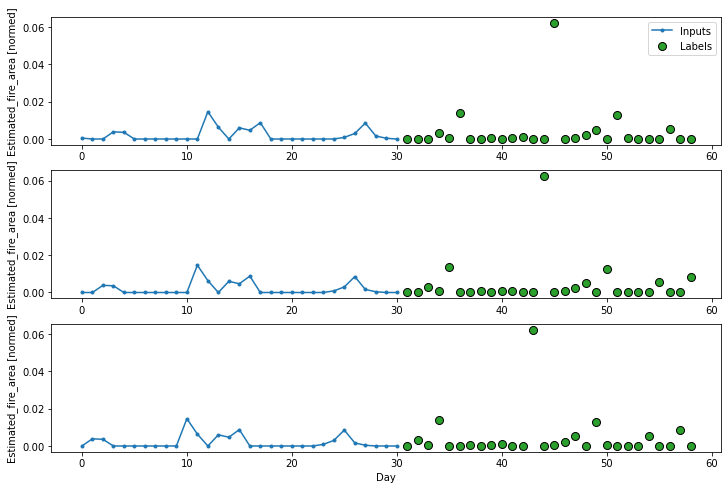

In [138]:
# WA region data
IN_STEPS = 31
OUT_STEPS = 28
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=shifts+OUT_STEPS,label_columns=['Estimated_fire_area'],
                              train_df=train_df, val_df=val_df, test_df=test_df,NSW_df=NSW_df)

multi_window.plot()
multi_window

In [42]:
# Each element is an (inputs, label) pair
multi_window.train.element_spec

(TensorSpec(shape=(None, 31, 99), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 28, 1), dtype=tf.float32, name=None))

In [43]:
def plot_history(history_object, plot_columns = ['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error']):
    fig_num = len(plot_columns)
    plt.figure(figsize=(12, 8))
    for n in range(fig_num):
        plt.subplot(fig_num, 1, n+1)
        plt.ylabel(plot_columns[n])
        plt.plot(history_object.history[plot_columns[n]])

In [44]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Dense(20),
    tf.keras.layers.GRU(30, return_sequences=True, return_state=False),
    tf.keras.layers.GRU(30), 
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS,1])
                          )])

Epoch 1/3
2310/2310 [==============================] - 123s 53ms/step - loss: 0.0101 - mean_absolute_error: 0.0101 - val_loss: 0.0134 - val_mean_absolute_error: 0.0134
Epoch 2/3
2310/2310 [==============================] - 105s 45ms/step - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0133 - val_mean_absolute_error: 0.0133
Epoch 3/3
2310/2310 [==============================] - 101s 44ms/step - loss: 0.0090 - mean_absolute_error: 0.0090 - val_loss: 0.0133 - val_mean_absolute_error: 0.0133


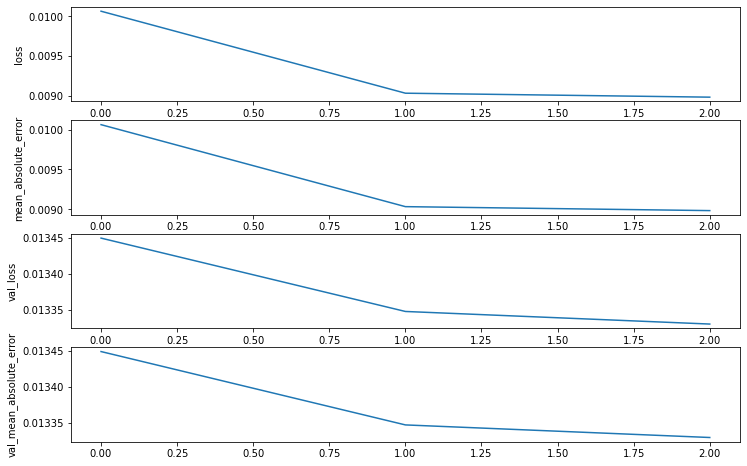

In [45]:
history2 = compile_and_fit(multi_lstm_model, multi_window, epochs=3)
plot_history(history2)

When I change to GRU instead of LSTM, it works better.

286/286 [==============================] - 3s 11ms/step - loss: 0.0128 - mean_absolute_error: 0.0128


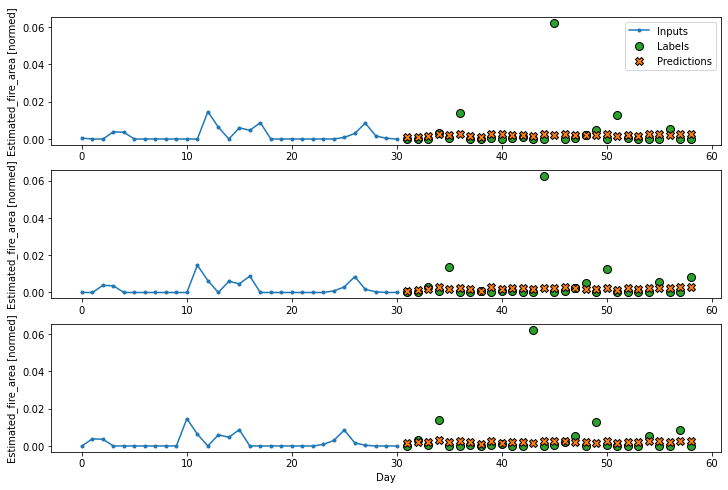

In [125]:
val_performance['M_LSTM'] = multi_lstm_model.evaluate(multi_window.val)
performance['M_LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Output of each State

In [47]:
multi_window.NSW

<MapDataset shapes: ((None, 31, 99), (None, 28, 1)), types: (tf.float32, tf.float32)>

In [139]:
NSW_Prediction = multi_lstm_model.predict(multi_window.NSW, verbose=1)

1/1 [==============================] - 0s 996us/step


I noticed that it happens when data is too little, like 8 images. I have removed sharding because I am working with extremely little data Also for the life of me I am struggling why would it cache the output of one script even if there is no sharding method anymore but it still keeps writing to terminal as if its writing them

In [140]:
NSW_Prediction.shape  #  it should be 28 x 1 !!

(4, 28, 1)

In [ ]:
CONV_WIDTH = 28
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*1,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_conv_model, multi_window, epochs=100)
plot_history(history)

In [ ]:
multi_conv_model.predict(multi_window.val)

In [ ]:
val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

Try Autoregressive model

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions


In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
print('prediction.shape', prediction.shape)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

In [ ]:
history_ar = compile_and_fit(feedback_model, multi_window, epochs=200)
plot_history(history_ar)

In [ ]:
val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

In [ ]:
# ref:
# https://towardsdatascience.com/using-lstm-autoencoders-on-multidimensional-time-series-data-f5a7a51b29a1
# https://machinelearningmastery.com/lstm-autoencoders/
window_length = 31
output_length = 28
feats = 55
autoencoder_model = tf.keras.Sequential([
#     keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'),
    keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'),
    keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'),
    keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'), 
    keras.layers.RepeatVector(output_length, name='encoder_decoder_bridge'),
    keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'),
    keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'),
    keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'),
    keras.layers.TimeDistributed(keras.layers.Dense(feats))
                          ])
# autoencoder_model = keras.Sequential()
# autoencoder_model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', batch_input_shape=(None, window_length, feats), return_sequences=True, name='encoder_1'))
# autoencoder_model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
# autoencoder_model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))
# autoencoder_model.add(keras.layers.RepeatVector(window_length, name='encoder_decoder_bridge'))
# autoencoder_model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
# autoencoder_model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
# autoencoder_model.add(keras.layers.LSTM(64, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
# autoencoder_model.add(keras.layers.TimeDistributed(keras.layers.Dense(feats)))
# autoencoder_model.compile(loss="mse",optimizer='adam')
# autoencoder_model.build()
# print(autoencoder_model.summary())

# autoencoder_model.fit(x=X, y=Y, validation_data=(XX, YY), epochs=100, batch_size=batch_size, shuffle=True, callbacks=[early_stop])
history_encode = compile_and_fit(autoencoder_model, multi_window, epochs=100)
plot_history(history_encode)

In [ ]:
val_performance['Encoder'] = autoencoder_model.evaluate(multi_window.val)
performance['Encoder'] = autoencoder_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(autoencoder_model)

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for example_inputs, example_labels in multi_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')